# Decode cypher text

### Welcome!
This notebook can decode cypher text. It uses a DFA created by the method outlined here
[Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576).

In this notebook will automatically train an RNN on symplfied set of english, and extract a DFA from that RNN.


# Code below

In [1]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Extraction import extract
import time
from memory_profiler import profile
import FalseWordGenerator as FWG

import ALPHABET_8
ALPHABET = ALPHABET_8.ALPHABET
print (ALPHABET)

['a', 'e', 'i', 'n', 'o', 'r', 's', 't']


In [2]:
MEANINGFUL_WORDS = ALPHABET_8.WORDS
MEANINGLESS_WORDS = FWG.generateFalseWords(ALPHABET, MEANINGFUL_WORDS)
def target(w):             
   if w.lower() in MEANINGFUL_WORDS:
      return True
   else:
      return False
    
train_set = {}
train_set.update({w: True for w in MEANINGFUL_WORDS})
train_set.update({w: False for w in MEANINGLESS_WORDS})
print ("made training set of size: " + str(len(train_set)))
print ("of which " + str(len(MEANINGFUL_WORDS)) + str(" are positive"))
print ("of which " + str(len(MEANINGLESS_WORDS)) + str(" are negative"))

made training set of size: 2039
of which 1031 are positive
of which 1014 are negative


# Train and Extract with the optimal network

In [3]:
rnnOpt = RNNClassifier(ALPHABET,num_layers=3,hidden_dim=50,RNNClass = LSTMNetwork)

The dy.parameter(...) call is now DEPRECATED.
        There is no longer need to explicitly add parameters to the computation graph.
        Any used parameter will be added automatically.


current average loss is:  0.32416513814092046
current average loss is:  0.1682077095287365
current average loss is:  0.025018542432818525


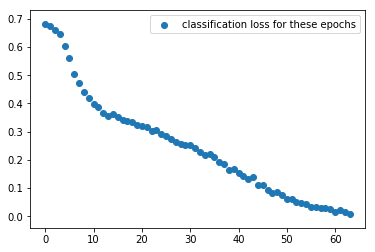

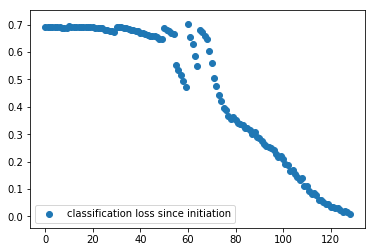

classification loss on last batch was: 0.008189856520553375


In [4]:
mixed_curriculum_train(rnnOpt,train_set,stop_threshold = 0.01)

In [5]:
all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
pos = next((w for w in all_words if rnnOpt.classify_word(w)==True),None)
neg = next((w for w in all_words if rnnOpt.classify_word(w)==False),None)
starting_examples = [w for w in [pos,neg] if not None == w]

In [6]:
rnnOpt.renew()

provided counterexamples are: ['an', 'as']
obs table refinement took 0.0
guided starting equivalence query for DFA of size 2


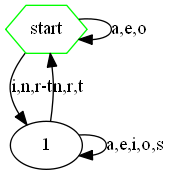

storing provided counterexample of length 2
returning counterexample of length 2:		an, this counterexample is accepted by the given RNN.
equivalence checking took: 0.041400384000013446
obs table refinement took 0.07
guided starting equivalence query for DFA of size 8


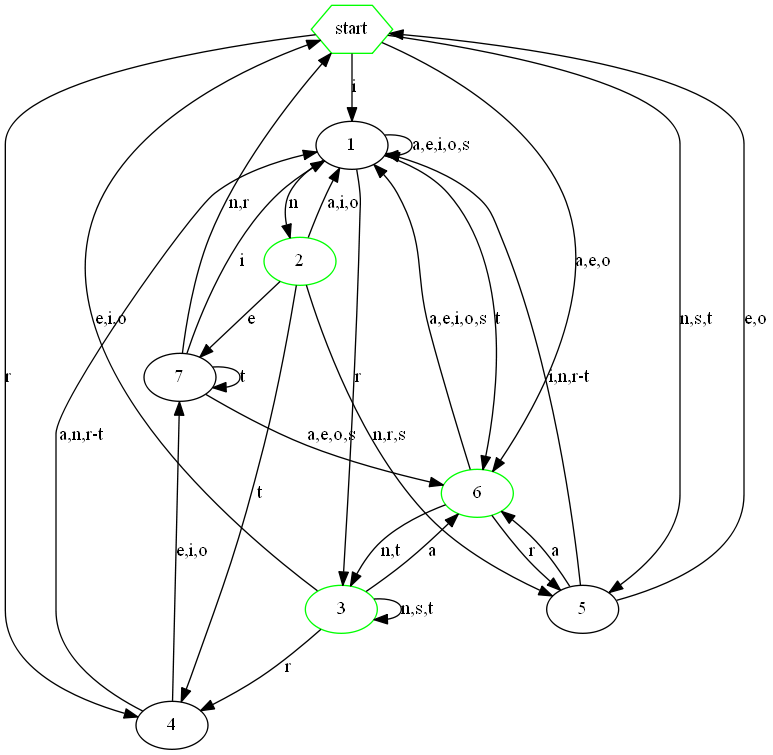

['', 'a']
refining, H size is 1
split wasn't perfect: gotta start over
['a', 'aa']
refining, H size is 1
['o', 'ao']
refining, H size is 1
['ee', 'ei']
returning counterexample of length 2:		er, this counterexample is accepted by the given RNN.
equivalence checking took: 0.7126706979999824
obs table refinement took 0.132
guided starting equivalence query for DFA of size 15


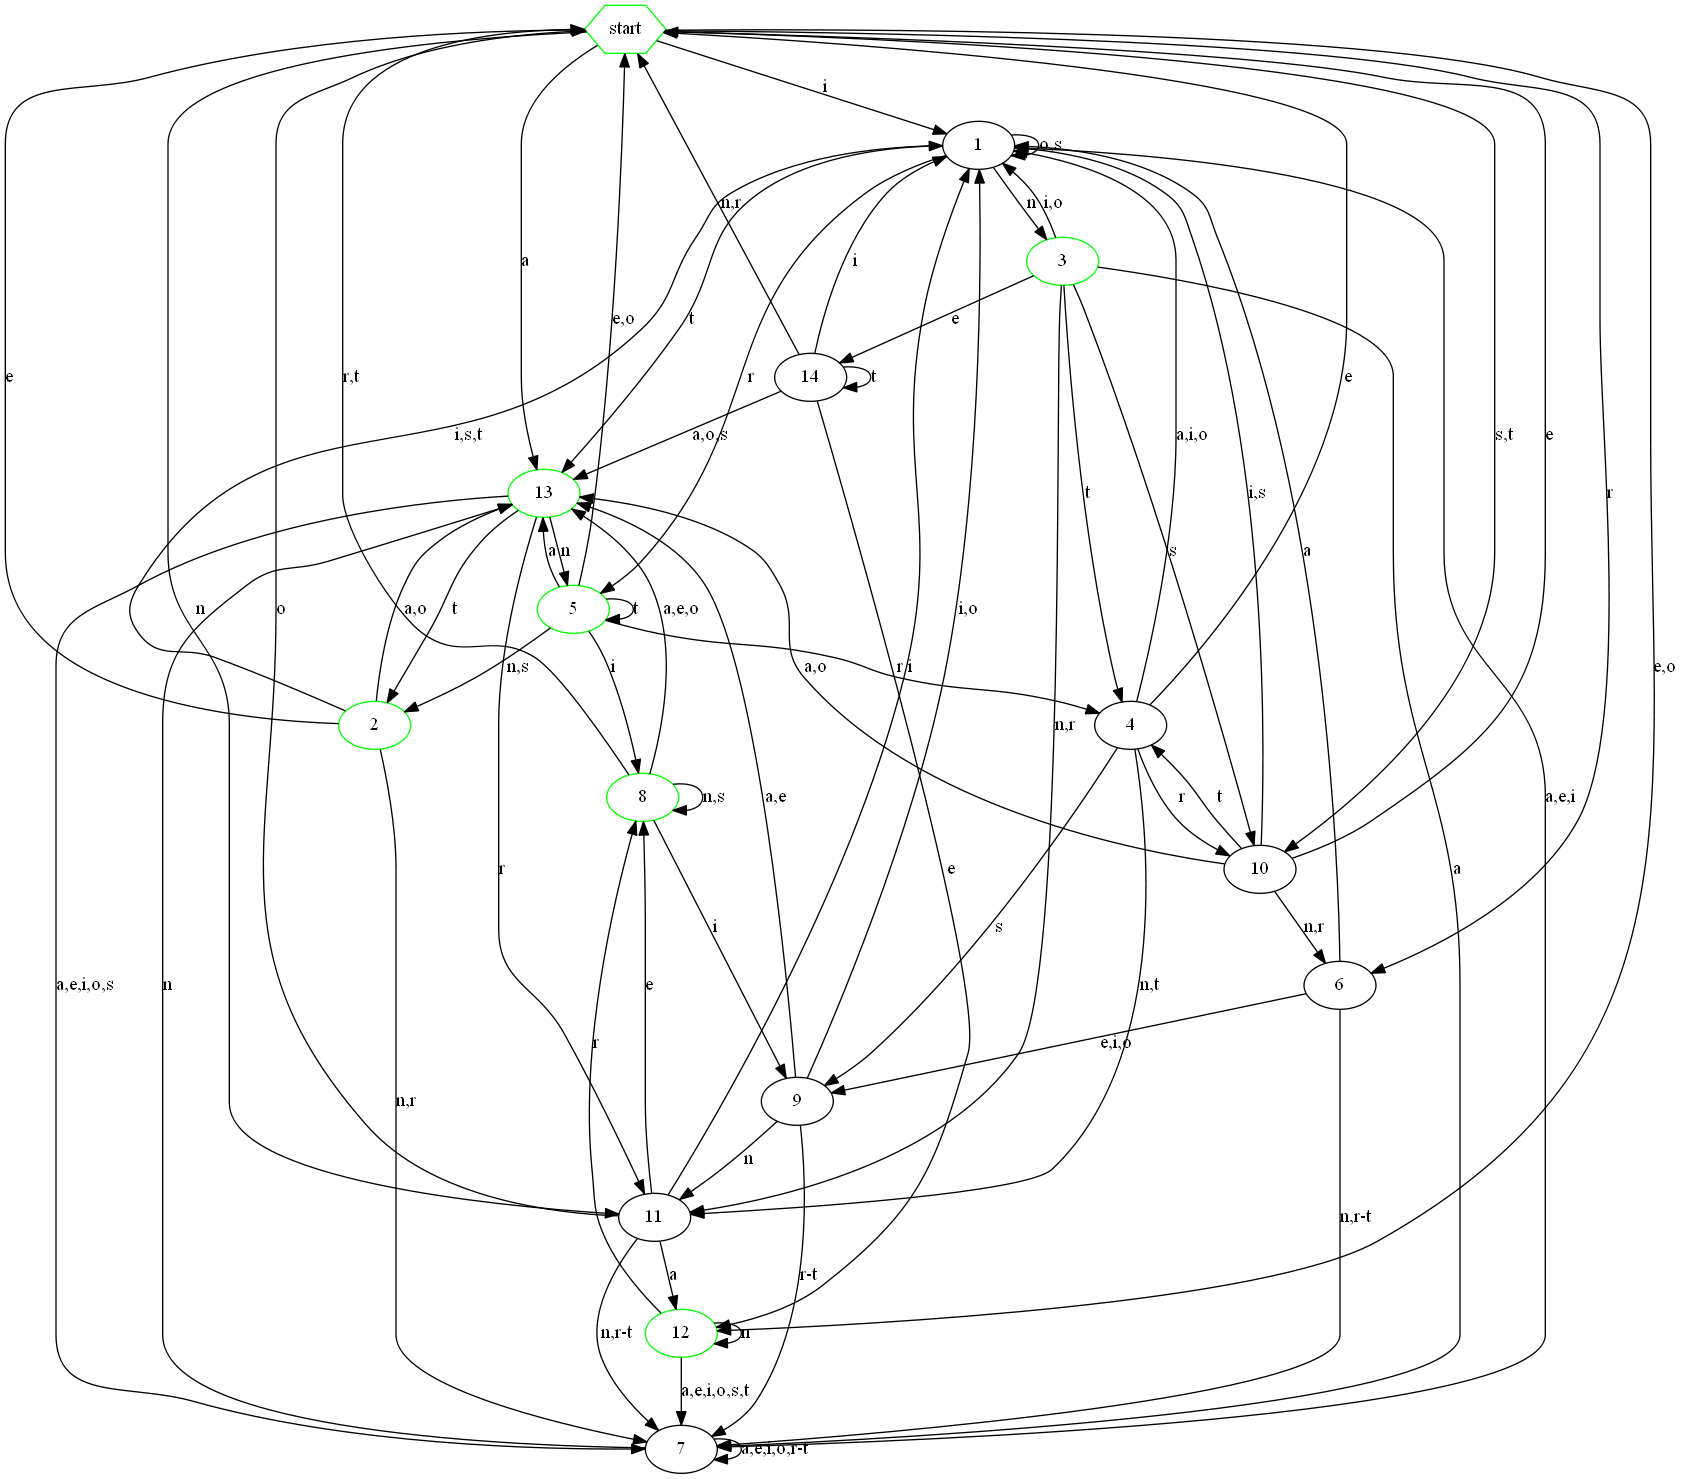

['ee', 'ei']
['e', 'ia']
refining, H size is 1
['n', 'in']
refining, H size is 1
['', 'ir']
returning counterexample of length 3:		irs, this counterexample is rejected by the given RNN.
equivalence checking took: 0.30461412299999324
obs table refinement took 1.164
guided starting equivalence query for DFA of size 52
['ee', 'ei']
['', 'ir']
refining, H size is 1
['n', 'nn']
refining, H size is 1
['', 'nr']
refining, H size is 1
['nn', 'nt']
['as', 'oi']
['en', 'on']
['oe', 'oo']
['os', 'ot']
returning counterexample of length 2:		ot, this counterexample is accepted by the given RNN.
equivalence checking took: 0.05388559699997586
obs table refinement took 4.038
guided starting equivalence query for DFA of size 121
['ee', 'ei']
['nn', 'nt']
['as', 'oi']
refining, H size is 1
['en', 'on']
returning counterexample of length 6:		enntan, this counterexample is accepted by the given RNN.
equivalence checking took: 0.044142542000003004
obs table timed out
observation table timed out during refi

In [7]:
dfaOpt = extract(rnnOpt,time_limit = 60, initial_split_depth = 10, starting_examples = starting_examples)

# Cypher some messages

In [8]:
#import cypher_creation as cypher
#a,e,i,n,o,r,s,t
messageOne = "tea is rotten"
cypherOne = ['aie','nt','sraaio']



In [10]:
import Rotation_Checker as RCT
RCT.rtCyChecker(cypherOne, ALPHABET, rnnOpt, dfaOpt)        # Call above functions

Try message in following list 
 [['eni', 'oa', 'tseenr'], ['ion', 're', 'atiios'], ['nro', 'si', 'eannrt'], ['osr', 'tn', 'ieoosa'], ['rts', 'ao', 'nirrte'], ['sat', 'er', 'onssai'], ['tea', 'is', 'rotten']]
RNN execution time 0.004985809326171875
DFA execution time 0.0
No rotation cyphered message founded


#### 3.4. Get stats
Display the extracted DFA by using the `draw_nicely` function, which has optional parameters `maximum` (default $60$) and `force` (default `False`), and will only draw the DFA if it has less than `maximum` states or `force` is set to `True`.

Print some statistics you might find interesting about the network, such as the trained RNN's accuracy against its target, the extracted DFA's accuracy against the RNN, and the extracted DFA's accuracy against the original RNN's target.

In [ ]:

from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfaOpt.draw_nicely(maximum=300) #max size willing to draw

test_set = train_set 
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==target(w)])
print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")


Rotation Cypher Checker

NameError: name 'message' is not defined